# Building a Book Recommendation System Using Machine Learning Models

## Importing Libraries

In [1]:
import re
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

random.seed(1)

import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [2]:
filepath = "../data/books.csv"
books_df = pd.read_csv(filepath, on_bad_lines='skip')

In [3]:
# Look at the first few rows 
books_df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


#### Get informations about the data

In [4]:
books_df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

**Columns Description:**

- **bookID**: A unique Identification number for each book.
- **title**: The name under which the book was published.
- **authors**: Names of the authors of the book. Multiple authors are separated by a slash (/).
- **average_rating**: The average rating that the book received overall.
- **isbn**: A unique 10-digit International Standard Book Number (ISBN) used to identify the book.
- **isbn13**: A 13-digit ISBN introduced in 2007 to replace the 10-digit format for international standardization.
- **language_code**: The primary language of the book (e.g., **eng** for English).
- **num_pages**: The total number of pages in the book.
- **ratings_count**: The total number of ratings that the book received.
- **text_reviews_count**: The total number of written text reviews for the book.
- **publication_date**: The date when the book was published.
- **publisher**: The name of the company or organization that published the book.


**Note:**
- **average_rating** reflects the **_quality_** of feedback based on scores given.
- **ratings_count** reflects the **_quantity_** of feedback or popularity based on the number of users who rated the book.

In [5]:
# Remove any leading or trailing whitespace in column names like " num_pages"
books_df.columns = books_df.columns.str.strip()

In [6]:
books_df["average_rating"].value_counts()

average_rating
4.00    219
3.96    195
4.02    178
3.94    176
4.07    172
       ... 
4.91      1
3.10      1
3.03      1
2.99      1
2.33      1
Name: count, Length: 209, dtype: int64

In [7]:
min_avg_rat = books_df["average_rating"].min()
max_avg_rat = books_df["average_rating"].max()

print(f"Minimum average_rating : {min_avg_rat}")
print(f"Maximum average_rating : {max_avg_rat}")

Minimum average_rating : 0.0
Maximum average_rating : 5.0


In [8]:
books_df["ratings_count"].value_counts()

ratings_count
3         82
0         80
1         76
2         71
4         71
          ..
21507      1
6970       1
108440     1
66503      1
783        1
Name: count, Length: 5294, dtype: int64

In [9]:
min_rat = books_df["ratings_count"].min()
max_rat = books_df["ratings_count"].max()

print(f"Minimum ratings_count : {min_rat}")
print(f"Maximum ratings_count : {max_rat}")

Minimum ratings_count : 0
Maximum ratings_count : 4597666


In [10]:
min_text_rev = books_df["text_reviews_count"].min()
max_text_rev = books_df["text_reviews_count"].max()

print(f"Minimum text_reviews_count : {min_text_rev}")
print(f"Maximum text_reviews_count : {max_text_rev}")

Minimum text_reviews_count : 0
Maximum text_reviews_count : 94265


In [11]:
min_num_pages = books_df["num_pages"].min()
max_num_pages = books_df["num_pages"].max()

print(f"Minimum num_pages : {min_num_pages}")
print(f"Maximum num_pages : {max_num_pages}")

Minimum num_pages : 0
Maximum num_pages : 6576


In [12]:
print(books_df.shape)
print(f"The dataset contains {books_df.shape[0]} rows and {books_df.shape[1]} columns.")

(11123, 12)
The dataset contains 11123 rows and 12 columns.


In [13]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7   num_pages           11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [14]:
# Check duplicated values
books_df.duplicated().sum()

0

In [15]:
# Check null values
books_df.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

In [16]:
books_df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


In [17]:
# Display the frequency of each publisher
books_df["publisher"].value_counts()

publisher
Vintage                        318
Penguin Books                  261
Penguin Classics               184
Mariner Books                  150
Ballantine Books               144
                              ... 
University of Calgary Press      1
Marlowe & Company                1
University Press of America      1
Abstract Studio                  1
VeloPress                        1
Name: count, Length: 2290, dtype: int64

## Exploration Data Analysis (EDA)

### Univariate Analysis

In [18]:
# Create a copy of the dataframe
books_dfCopy = books_df.copy()

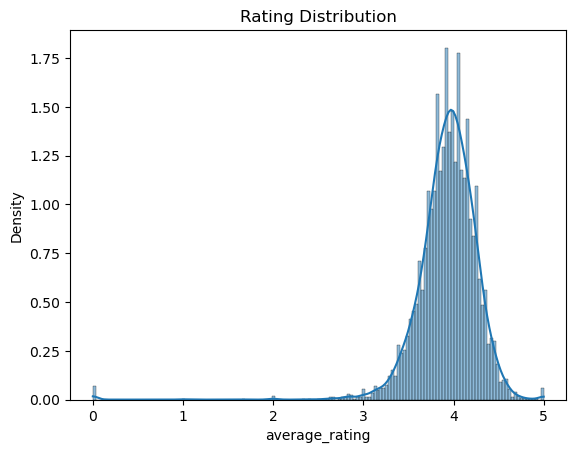

In [19]:
# Rating Distribution
sns.histplot(books_dfCopy['average_rating'], kde=True, stat="density")
plt.title("Rating Distribution");

- The rating distribution plot suggests that most ratings fall within the range of 3.5 to 4.5.
- Only a small number of books have achieved a perfect rating of 5.

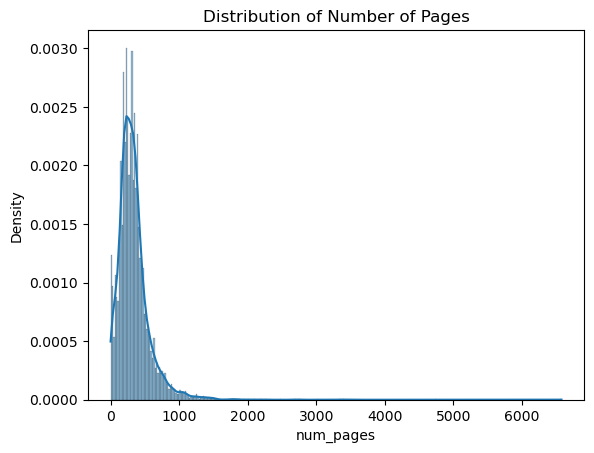

In [20]:
# Distribution of Number of Pages
sns.histplot(books_dfCopy['num_pages'], kde=True, stat="density")
plt.title("Distribution of Number of Pages");

- The distribution plot above reveals that most books have fewer than 1000 pages.
- The highest page counts are in the 5000-7000 page range, but only a few books fall into this category.

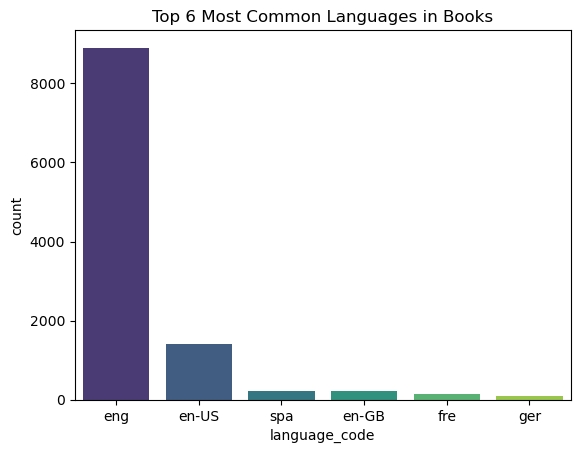

In [21]:
# The most common using n language
top_n_lang = 6
language_code = books_dfCopy.value_counts('language_code').sort_values(ascending=False)

sns.barplot(x=language_code.index[:top_n_lang], y=language_code[:top_n_lang], palette='viridis')
plt.title(f"Top {top_n_lang} Most Common Languages in Books");

The graph shows that most books are in English (**eng**), with some categorized as **en-US**, **spa**, **en-GB**, **fre**, and **ger**.

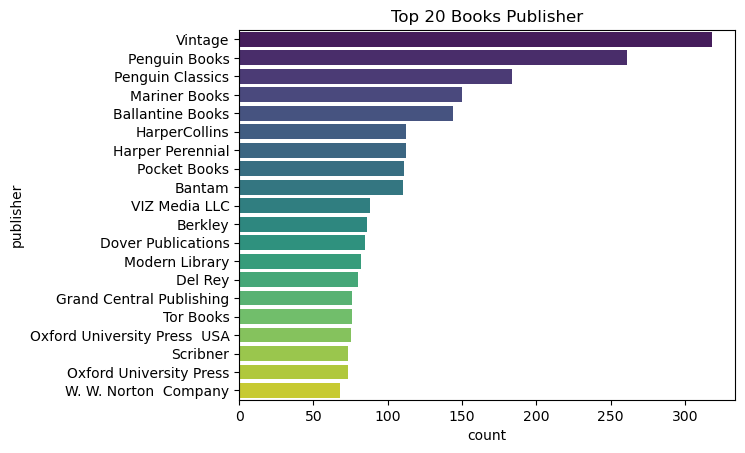

In [22]:
# Top n Books Publisher
top_n_books = 20
publisher = books_dfCopy.value_counts('publisher').sort_values(ascending=False).head(top_n_books)

sns.barplot(y=publisher.index, x=publisher, palette='viridis')
plt.title(f"Top {top_n_books} Books Publisher");

The above plot shows that **Vintage** and **Penguin Books** are the publishers with the most books, each having over 250 titles.

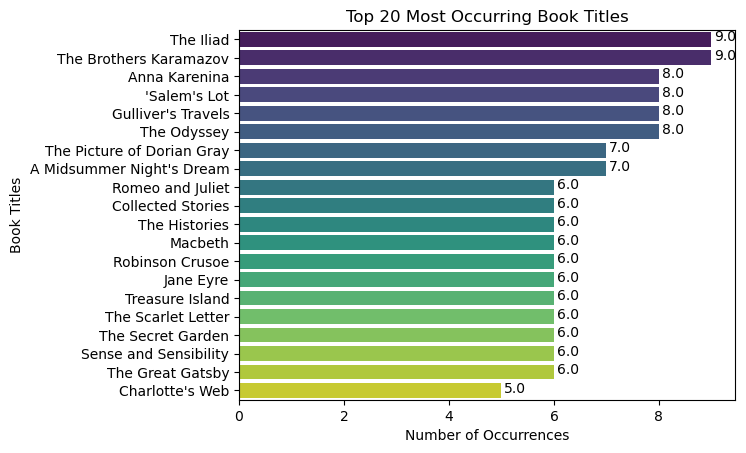

In [23]:
# Top n Most Occurring Book Titles
top_n_occ_books = 20
title = books_dfCopy.value_counts('title').sort_values(ascending=False).head(top_n_occ_books)

ax = sns.barplot(y=title.index, x=title, palette='viridis')

for i in ax.patches:
    ax.text(i.get_width() + .05, i.get_y() + 0.5, str(i.get_width()))
    
plt.title(f"Top {top_n_occ_books} Most Occurring Book Titles")
plt.xlabel("Number of Occurrences")
plt.ylabel('Book Titles');

We can see that **The lliad** and **The Brothers Karamazov** have the highest number of oocurance.

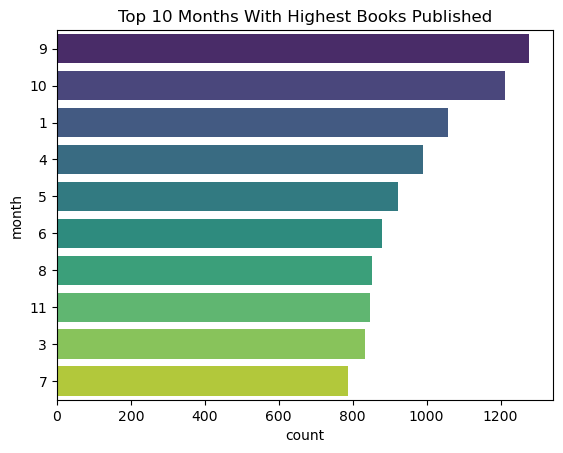

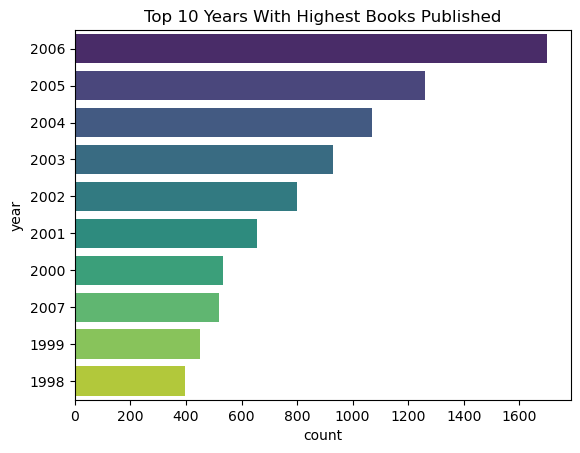

In [24]:
# Top n Months and Years With Highest Books Published 
months=[]
year=[]
for i in books_dfCopy['publication_date']:
    months.append(i.split('/')[0])
    year.append(i.split('/')[2])

books_dfCopy['year'] = year
books_dfCopy['month'] = months

# Month
top_n_month = 10
month = books_dfCopy['month'].value_counts().head(top_n_month)

sns.barplot(y=month.index, x=month, palette='viridis')
plt.title(f"Top {top_n_month} Months With Highest Books Published")


# Year
top_n_year = 10
year = books_dfCopy['year'].value_counts().head(top_n_year)

plt.figure()
sns.barplot(y=year.index, x=year, palette='viridis')
plt.title(f"Top {top_n_year} Years With Highest Books Published");

The most books were published in **January**, **September**, and **October** of the years **2005** and **2006**.

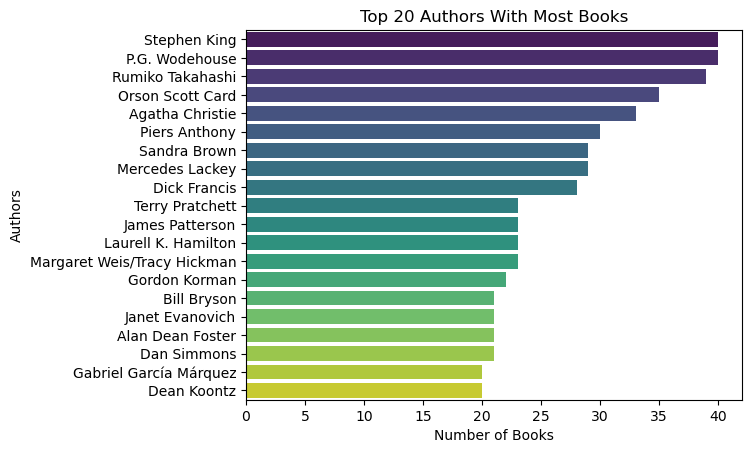

In [25]:
# Top n Authors with Most Books
top_n = 20

# Count the number of books per author
author_counts = books_dfCopy['authors'].value_counts().head(top_n)

# Create a DataFrame with the counts
author_books = author_counts.reset_index()
author_books.columns = ['authors', 'number_of_books']

# Plotting the data
sns.barplot(x='number_of_books', y='authors', data=author_books, palette='viridis')
plt.title(f"Top {top_n} Authors With Most Books")
plt.xlabel("Number of Books")
plt.ylabel("Authors");

**Stephen King**, **P.G. Wodehouse**, and **Rumiko Takahashi** have the most books, with over 35 each.

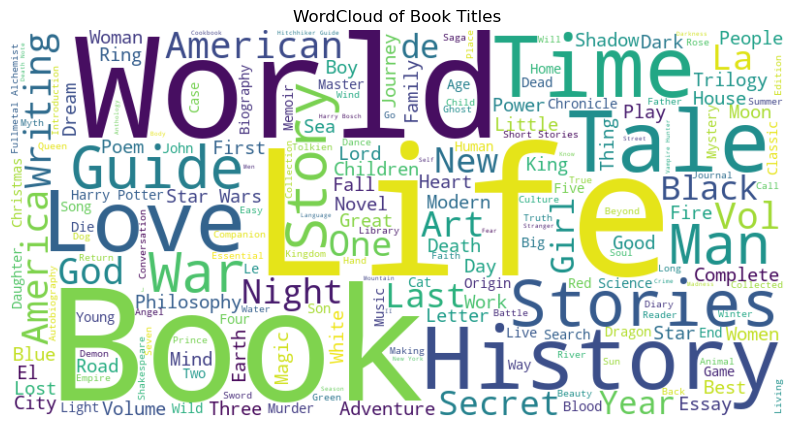

In [26]:
# Combine all book titles into a single text string
text = " ".join(title for title in books_dfCopy['title'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for the wordcloud
plt.title("WordCloud of Book Titles")
plt.show()

##### Conclusion of Univariate Analysis

- Rating Distribution: Most books have ratings between **3.5** and **4.5**, with few getting a perfect **5**.
- Page Count: Most books are under **1000** pages, with some very long books (**5000-7000** pages).
- Languages: Most books are in **English**, with some in **Spanish**, **French**, and **German**.
- Publishers: **Vintage** and **Penguin Books** have the most titles, each over 250.
- Most Common Books: **The Iliad** and **The Brothers Karamazov** are the most frequent books.
- Publication Trends: The most books were published in **January**, **September**, and **October**, mainly in **2005** and **2006**.
- Top Authors: *Stephen King*, *P.G. Wodehouse*, and *Rumiko Takahashi* have the most books, over 35 each.

### Bivariate Analysis

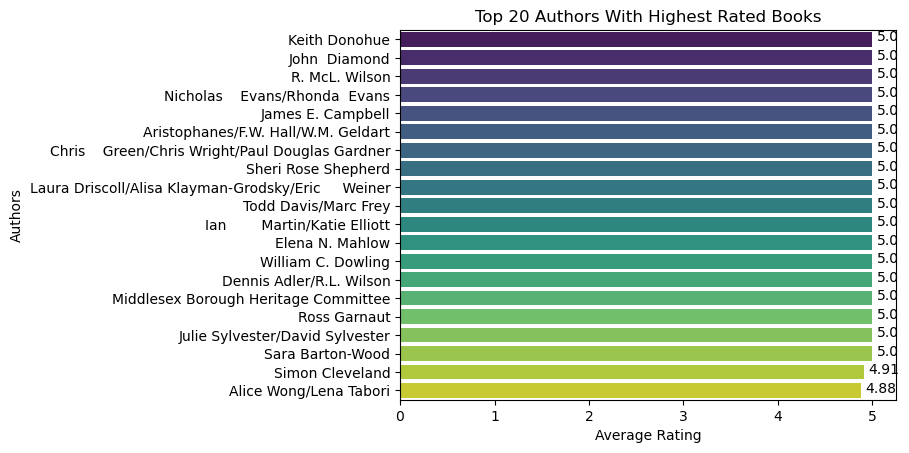

In [27]:
# Top n Authors with Highest Rated Books

top_n = 20

# Calculate the average rating per author
author_avg_rating = books_dfCopy.groupby('authors')['average_rating'].mean().sort_values(ascending=False).head(top_n)

# Create a DataFrame with the average ratings
author_ratings = author_avg_rating.reset_index()
author_ratings.columns = ['authors', 'average_rating']

# Plotting the data
ax = sns.barplot(x='average_rating', y='authors', data=author_ratings, palette='viridis')

for i in ax.patches:
    ax.text(i.get_width() + .05, i.get_y() + 0.5, str(i.get_width()))
    
plt.title(f"Top {top_n} Authors With Highest Rated Books")
plt.xlabel("Average Rating")
plt.ylabel("Authors");

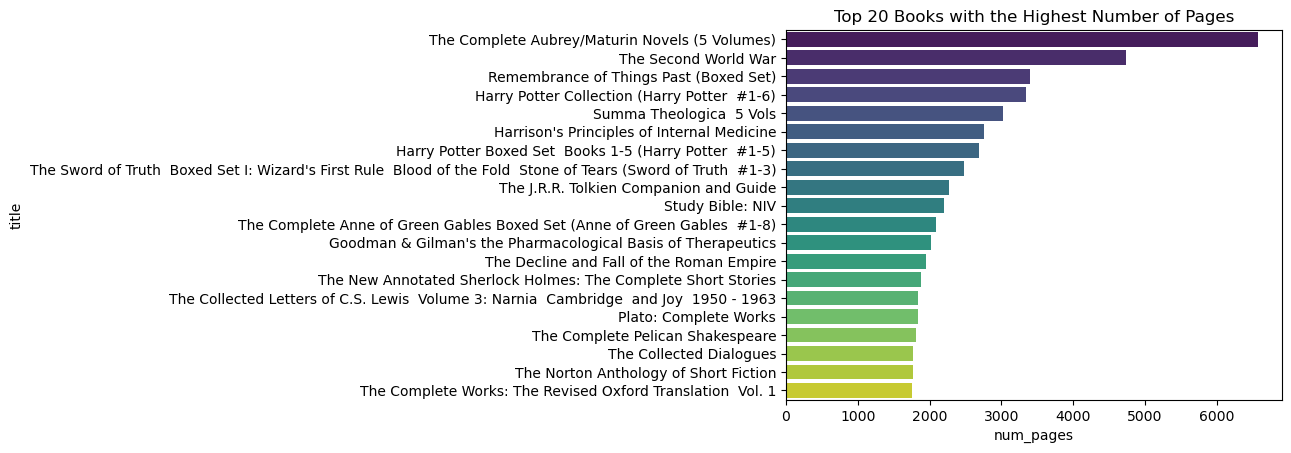

In [28]:
# Select top n books with the highest number of pages
top_n = 20
x = books_dfCopy.loc[:, ['title', 'num_pages']].sort_values(by=['num_pages'], ascending=False).head(top_n)

# Plotting the data
sns.barplot(y='title', x='num_pages', data=x, palette='viridis')
plt.title(f"Top {top_n} Books with the Highest Number of Pages");

- The book title **The Complete Aubrey/Maturin Novels (5 Volumes)** has the highest number of pages, with over 6000 pages. 
- **The Second World War** comes second, with approximately 4700 pages.

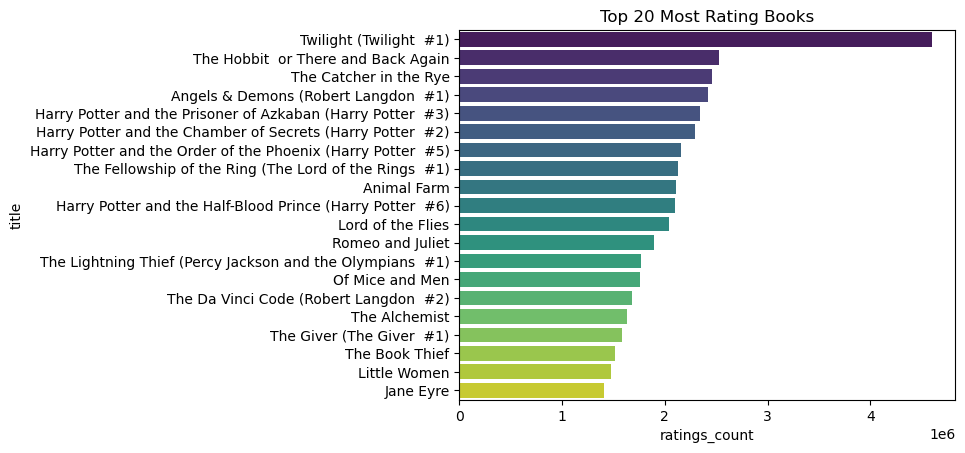

In [29]:
# Select top n most rating books
top_n = 20
x = books_dfCopy.loc[:, ['title', 'ratings_count']].sort_values(by=['ratings_count'], ascending=False).head(top_n)

# Plotting the data
sns.barplot(y='title', x='ratings_count', data=x, palette='viridis')
plt.title(f"Top {top_n} Most Rating Books");

The plot above shows that Twilight (Twilight #1) has the most ratings books.

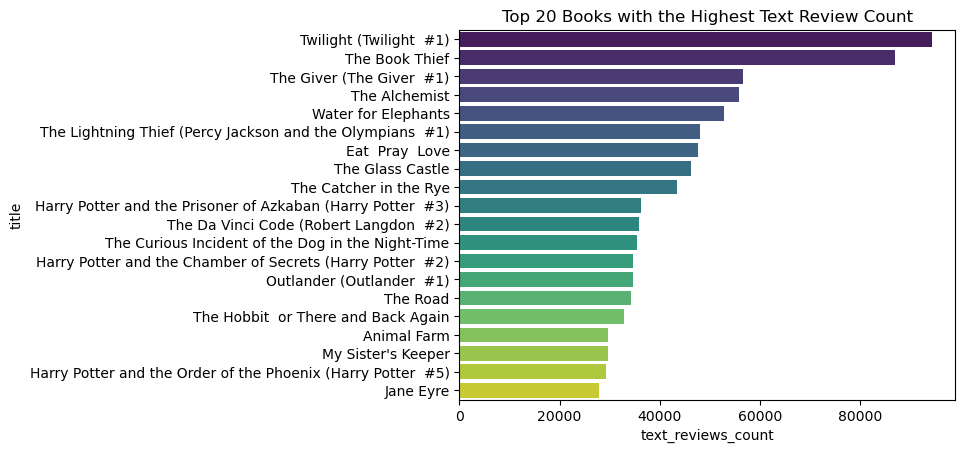

In [30]:
# Select top n books with the highest text review count books
top_n = 20 
x = books_dfCopy.loc[:,['title', 'text_reviews_count']].sort_values(by=['text_reviews_count'],ascending = False).head(top_n)

sns.barplot(y ='title', x='text_reviews_count', data = x, palette='viridis')
plt.title(f"Top {top_n} Books with the Highest Text Review Count");

- The book **Twilight (Twilight #1)** has the highest number of text reviews, with over 90,000. 
- **The Book Thief** follows as the second highest, with around 85,000 reviews.

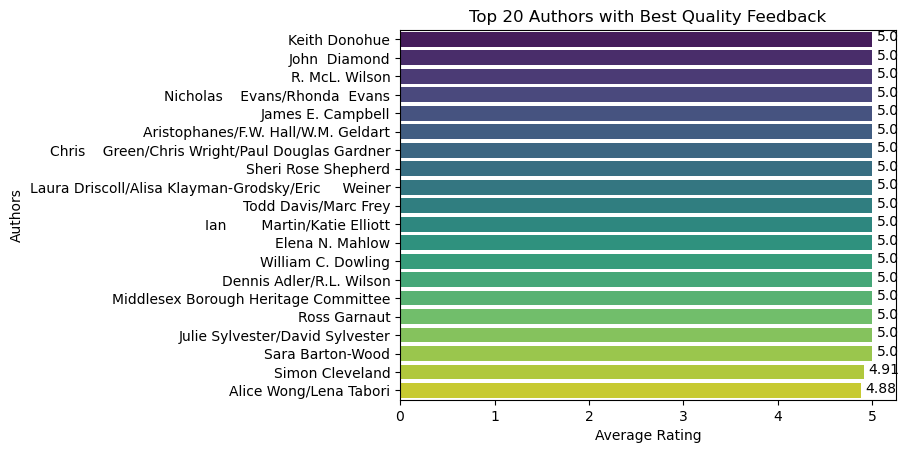

In [31]:
top_n = 20

# Top Authors by Quality (Average Rating)
top_quality_authors = (books_df.groupby('authors')['average_rating'].mean().sort_values(ascending=False).head(top_n))

# Plotting the Top Authors by Quality
ax = sns.barplot(y=top_quality_authors.index, x=top_quality_authors.values, palette='viridis')

for i in ax.patches:
    ax.text(i.get_width() + .05, i.get_y() + 0.5, str(i.get_width()))
    
plt.title(f"Top {top_n} Authors with Best Quality Feedback")
plt.xlabel("Average Rating")
plt.ylabel("Authors")
plt.show()

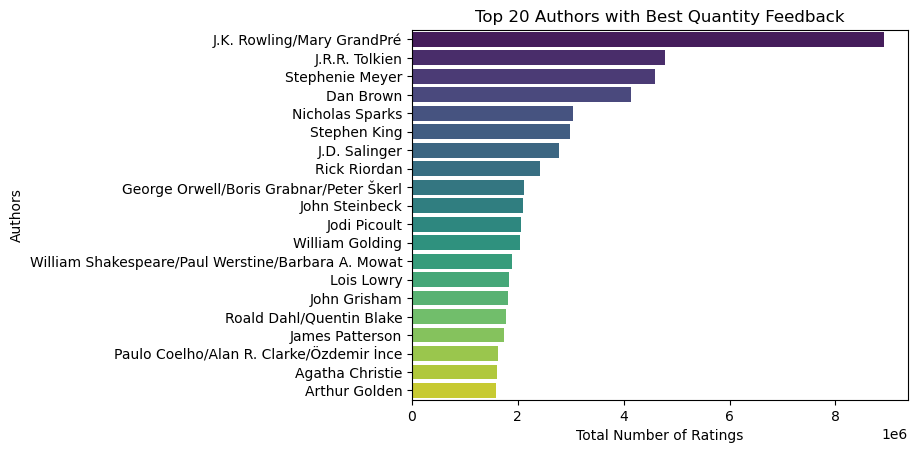

In [32]:
top_n = 20

# Top Authors by Quantity (Number of Ratings)
top_quantity_authors = (books_df.groupby('authors')['ratings_count'].sum().sort_values(ascending=False).head(top_n))

# Plotting the Top Authors by Quantity
sns.barplot(y=top_quantity_authors.index, x=top_quantity_authors.values, palette='viridis')
plt.title(f"Top {top_n} Authors with Best Quantity Feedback")
plt.xlabel("Total Number of Ratings")
plt.ylabel("Authors");


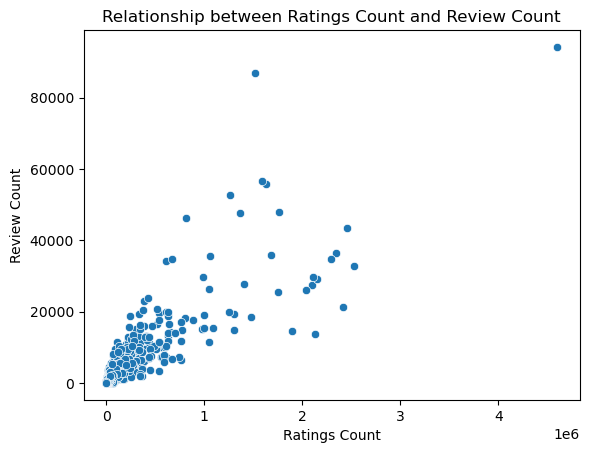

In [33]:
# Scatter plot for Relationship between Ratings Count and Review Count
sns.scatterplot(data=books_dfCopy, x='ratings_count', y='text_reviews_count')

# Adding title and labels
plt.title("Relationship between Ratings Count and Review Count")
plt.xlabel("Ratings Count")
plt.ylabel("Review Count");

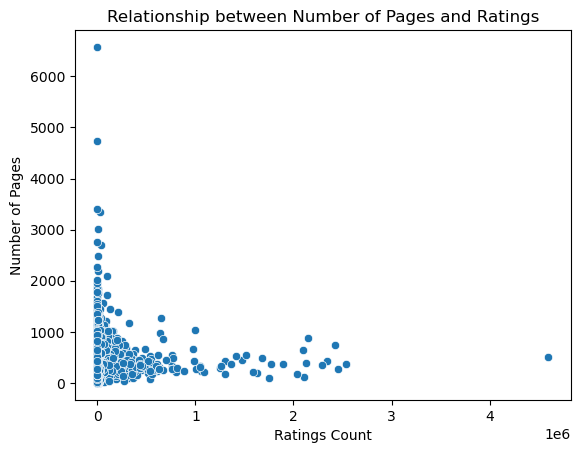

In [34]:
# Is there a relationship between number of pages and ratings?
sns.scatterplot(data=books_dfCopy, x='ratings_count', y='num_pages')

# Adding title and labels
plt.title("Relationship between Number of Pages and Ratings")
plt.xlabel("Ratings Count")
plt.ylabel("Number of Pages");

##### Conclusion of Bivariate Analysis

- Longest Books: "**The Complete Aubrey/Maturin Novels**" has the most pages (over 6000), followed by "*The Second World War*" with about 4700 pages.
- Most Rated: "**Twilight (Twilight #1)**" has the highest number of ratings.
- Most Text Reviews: "**Twilight (Twilight #1)**" also has the most text reviews (over 90,000), with "**The Book Thief**" second (around 85,000 reviews).
- Authors with the best feedback: **Keith Donohue, John Diamond, R. McL. Wilson, and Nicholas Evans/Rhonda Evans**, and many others.

### Multivariate Analysis

#### Correlation Analysis


In [35]:
# Do longer books (num_pages) receive higher or lower ratings on average?

# Calculate the correlation between num_pages and average_rating
correlation = books_df['num_pages'].corr(books_df['average_rating'])
print(f"Correlation between number of pages and average rating: {correlation:.2f}")

# Statistical test to check correlation significance
pearson_corr, p_value = stats.pearsonr(books_df['num_pages'], books_df['average_rating'])
print(f"Pearson correlation: {pearson_corr:.2f}, P-value: {p_value:.4f}")

Correlation between number of pages and average rating: 0.15
Pearson correlation: 0.15, P-value: 0.0000


- Longer books tend to have slightly higher ratings, but the effect is small.
- This result is significant, so it's likely not due to chance.

In [36]:
# Are books with more ratings_count generally rated higher or lower?

# Calculate the correlation between ratings_count and average_rating
correlation = books_df['ratings_count'].corr(books_df['average_rating'])
print(f"Correlation between ratings count and average rating: {correlation}")

# Statistical test to check correlation significance
pearson_corr, p_value = stats.pearsonr(books_df['ratings_count'], books_df['average_rating'])
print(f"Pearson correlation: {pearson_corr:.2f}, P-value: {p_value:.4f}")

Correlation between ratings count and average rating: 0.038223591811010385
Pearson correlation: 0.04, P-value: 0.0001


- The correlation between ratings count and average rating is very weak (0.04).
- The result is statistically significant, so it's unlikely to be due to chance.

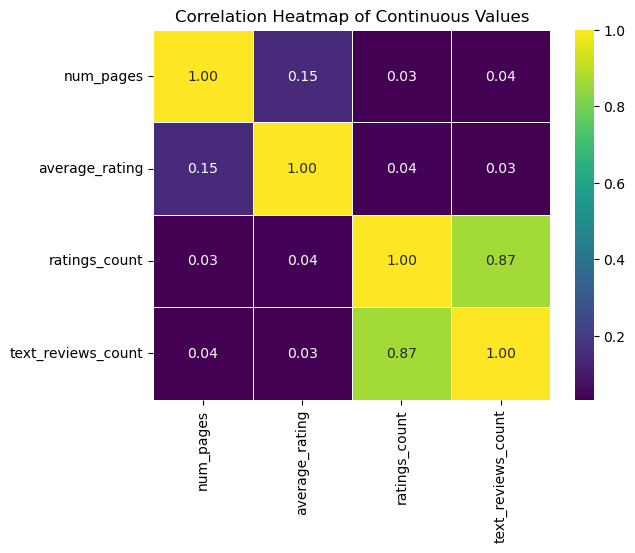

In [37]:
# Select continuous columns for the heatmap
continuous_columns = books_dfCopy[['num_pages', 'average_rating', 'ratings_count', 'text_reviews_count']]  

# Compute the correlation matrix
corr_matrix = continuous_columns.corr()

# Plot the heatmap
# plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5, cbar=True)

plt.title("Correlation Heatmap of Continuous Values",);

- A strong correlation of **0.87** between **ratings_count** and **text_reviews_count** means that books with more ratings also tend to have more text reviews.
- A weak correlation of **0.15** between **ratings_count** and **num_pages** means that longer books tend to have slightly more ratings, but the link is weak.

##### Conclusion of Multivariate Analysis

- Longer books tend to have slightly higher ratings.
- The correlation between book length and rating is likely real and not by chance.
- The link between ratings count and average rating is very weak.
- Books with more ratings also usually have more text reviews.
- Longer books have a weak connection to more ratings.

## Data Preprocessing

In [38]:
# We'll combine relevant columns such as title, authors, and publisher into a single text feature.
books_df['features'] = books_df['title'] + ' ' + books_df['authors'] + ' ' + books_df['publisher']

In [39]:
def preprocessed_data(data):
    # Lowercase the text
    data['features'] = data['features'].str.lower()

    # Remove special characters, numbers, and punctuation
    data['features'] = data['features'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

    # Remove extra spaces
    data['features'] = data['features'].str.replace(r'\s+', ' ', regex=True).str.strip()

    # Apply TF-IDF vectorizer
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(data['features'])
    
    return tfidf_matrix, tfidf

In [40]:
tfidf_matrix, tfidf = preprocessed_data(books_df)
# Checking the shape of the resulting TF-IDF matrix
print(tfidf_matrix.shape)

(11123, 23566)


Add some numerical features for NearestNeighbors modeling.

In [41]:
# Normalize numeric features to combine with TF-IDF vectors
scaler = MinMaxScaler()
numeric_features = scaler.fit_transform(books_df[['ratings_count', 'average_rating', 'text_reviews_count']])

# Combine TF-IDF matrix with scaled numeric features
combined_features_matrix = hstack([tfidf_matrix, numeric_features])

print(combined_features_matrix.shape)

(11123, 23569)


# Recommendation Engine

In [42]:
# Convert the combined features matrix to CSR format for efficient indexing
combined_features_matrix = csr_matrix(combined_features_matrix)

# Fit KNN model on the combined features matrix
knn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
knn_model.fit(combined_features_matrix)

# Define a function to recommend books based on a title
def recommend_books_knn(title, n_recommendations=5):
    # Check if the title exists in the dataset
    if title not in books_df['title'].values:
        return f"No book found with the title '{title}'. Please check the title and try again."
    
    # Find the index of the book that matches the title
    idx = books_df[books_df['title'] == title].index[0]
    
    # Find the nearest neighbors for the chosen book
    distances, indices = knn_model.kneighbors(combined_features_matrix[idx], n_neighbors=n_recommendations + 1)
    
    # Get the recommended books, excluding the input book itself
    recommended_indices = indices.flatten()[1:]
    recommended_books = books_df.iloc[recommended_indices][['title', 'authors', 'publication_date', 'publisher', 'average_rating']]
    
    return recommended_books


In [43]:
user_query = "Harry Potter and the Half-Blood Prince (Harry Potter  #6)"
recommendations = recommend_books_knn(user_query, n_recommendations=5)

print(f"Recommendations for : '{user_query}'\n {recommendations}")

Recommendations for : 'Harry Potter and the Half-Blood Prince (Harry Potter  #6)'
                                                   title  \
1     Harry Potter and the Order of the Phoenix (Har...   
3     Harry Potter and the Prisoner of Azkaban (Harr...   
4415  Harry Potter and the Chamber of Secrets (Harry...   
4     Harry Potter Boxed Set  Books 1-5 (Harry Potte...   
615   Harry Potter and the Half-Blood Prince (Harry ...   

                         authors publication_date  \
1     J.K. Rowling/Mary GrandPré         9/1/2004   
3     J.K. Rowling/Mary GrandPré         5/1/2004   
4415  J.K. Rowling/Mary GrandPré         6/2/1999   
4     J.K. Rowling/Mary GrandPré        9/13/2004   
615                 J.K. Rowling        6/23/2006   

                                     publisher  average_rating  
1                              Scholastic Inc.            4.49  
3                              Scholastic Inc.            4.56  
4415  Arthur A. Levine Books / Scholastic Inc.  

In [44]:
user_query = "fantasy books about Food"
recommendations = recommend_books_knn(user_query, n_recommendations=5)

print(f"Recommendations for : '{user_query}'\n {recommendations}")

Recommendations for : 'fantasy books about Food'
 No book found with the title 'fantasy books about Food'. Please check the title and try again.


The limitation with this KNN approach is that the user must enter the exact book title as it appears in the dataset. If no match is found, the model will display: 'Please check the title and try again.'

### Content-Based Recommender System

In [45]:
def recommender_engine(query, top_n=5):
    # Vectorize the user's input
    query_vec = tfidf.transform([query])
    
    # Calculate cosine similarity between the query and all books
    cosine_similarities = cosine_similarity(query_vec, tfidf_matrix)
    
    # Get the indices of the top N most similar books
    similar_books_indices = cosine_similarities.argsort()[0][-top_n:][::-1]
    
    # Get the top N most similar books based on cosine similarity
    top_books = books_dfCopy.iloc[similar_books_indices][['title', 'authors', 'publication_date', 'publisher', 'average_rating']]
    
    return top_books

In [46]:
# User types a sentence and the model return top N books
user_query = "fantasy books about Food"
top_n_books = recommender_engine(user_query, top_n=5)

print(f"Recommendations for : '{user_query}'\n {top_n_books}")

Recommendations for : 'fantasy books about Food'
                                                   title  \
1158  Holy Cows and Hog Heaven: The Food Buyer's Gui...   
9842                      Feast: Food to Celebrate Life   
9780  When Food Is Love: Exploring the Relationship ...   
332   Fast Food Nation: What The All-American Meal i...   
3032           Father Hunger: Fathers  Daughters & Food   

                           authors publication_date       publisher  \
1158   Joel Salatin/Michael Pollan        2/19/2005        Polyface   
9842                Nigella Lawson       10/27/2004  Hachette Books   
9780                   Geneen Roth         7/1/1992     Plume Books   
332                 Eric Schlosser         4/4/2002   Penguin Books   
3032  Margo Maine/Craig L. Johnson         9/1/2003     Gurze Books   

      average_rating  
1158            4.01  
9842            4.15  
9780            4.04  
332             3.74  
3032            3.57  


In [47]:
user_query = "Harry Potter and the Half-Blood Prince" 
top_n_books = recommender_engine(user_query, top_n=5)

print(f"Recommendation for : '{user_query}'\n {top_n_books}")

Recommendation for : 'Harry Potter and the Half-Blood Prince'
                                                    title  \
615    Harry Potter and the Half-Blood Prince (Harry ...   
0      Harry Potter and the Half-Blood Prince (Harry ...   
6           Harry Potter Collection (Harry Potter  #1-6)   
10675  Harry Potter and the Goblet of Fire (Harry Pot...   
2      Harry Potter and the Chamber of Secrets (Harry...   

                          authors publication_date              publisher  \
615                  J.K. Rowling        6/23/2006  Bloomsbury Publishing   
0      J.K. Rowling/Mary GrandPré        9/16/2006        Scholastic Inc.   
6                    J.K. Rowling        9/12/2005             Scholastic   
10675                J.K. Rowling         7/8/2000             Bloomsbury   
2                    J.K. Rowling        11/1/2003             Scholastic   

       average_rating  
615              4.57  
0                4.57  
6                4.73  
10675            

With cosine similarity, results are more flexible and accurate. The function can handle any user input and will return the books most similar to the user’s query, even if the title isn’t an exact match.